## Семинар 7: "Методы оптимизации"

ФИО: Находнов Максим Сергеевич

In [1]:
import numpy as np

import copy

import math

import sys

from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision import transforms

/home/m.nakhodnov/anaconda3/envs/py2.7.14/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [2]:
class Funcional():
    def __init__(self, f, df, init):
        self.f = f
        self.df = df
        self.parameters = {'point' : init}
        
    def evaluate(self, point=None):
        if point is not None:
            return self.f(point)            
        return self.f(self.parameters['point'])
    
    def derivative(self, point=None):
        if point is not None:
            return self.df(point)            
        return self.df(self.parameters['point'])

In [3]:
class Optimizer():
    def __init__(self, func):
        self.func = copy.deepcopy(func)
        
    def step(self):
        raise RuntimeError('Not implemented. Descended class must overrite this function')
    
class GD(Optimizer):
    def __init__(self, func, lr):
        Optimizer.__init__(self, func)
        self.lr = lr
        
    def step(self):
        # Math:
        # dTetta = lr * df
        
        df = self.func.derivative()
        for name, value in self.func.parameters.iteritems():
            self.func.parameters[name] -= self.lr * df
            
class Momentum(GD):
    def __init__(self, func, lr, gamma):
        GD.__init__(self, func, lr)
        self.gamma = gamma
        self.gradE = {}
        for name, value in self.func.parameters.iteritems():
            self.gradE[name] = 0
        
    def step(self):
        # Math:
        # gradE = gamma * gradE + lr * df
        # dTetta = gradE
        
        df = self.func.derivative()
        for name, value in self.func.parameters.iteritems():
            self.gradE[name] = self.gamma * self.gradE[name] + self.lr * df
            self.func.parameters[name] -= self.gradE[name]
            
class NAG(Momentum):
    def __init__(self, func, lr, gamma):
        Momentum.__init__(self, func, lr, gamma)
        
    def step(self):
        # Math:
        # gradE = gamma * gradE + lr * df(Tetta - gamma * gradE)
        # dTetta = gradE
        
        for name, value in self.func.parameters.iteritems():
            df = self.func.derivative(value - self.gamma * self.gradE[name])
            self.gradE[name] = self.gamma * self.gradE[name] + self.lr * df
            self.func.parameters[name] -= self.gradE[name]
            
    
class Adagrad(GD):
    def __init__(self, func, lr, eps):
        GD.__init__(self, func, lr)
        self.eps = eps
        self.G = {}
        for name, value in self.func.parameters.iteritems():
            self.G[name] = np.zeros_like(value)
        
    def step(self):
        # Math:
        # G += df ** 2
        # dTetta = lr / sqrt(G + eps) * df
        
        df = self.func.derivative()
        for name, value in self.func.parameters.iteritems():
            self.G[name] += df ** 2
            self.func.parameters[name] -= self.lr / np.sqrt(self.G[name] + self.eps) * df
            
class Adadelta(GD):
    def __init__(self, func, lr, gamma, eps):
        GD.__init__(self, func, lr)
        self.gamma = gamma
        self.eps = eps
        self.dTettaSqE = {}
        self.dgradSqE = {}
        for name, value in self.func.parameters.iteritems():
            self.dTettaSqE[name] = np.zeros_like(value)
            self.dgradSqE[name] = np.zeros_like(value)
        
    def step(self):
        # Math:
        # dgradSqE = gamma * dgradSqE + (1 - gamma) * df ** 2
        # dTetta = lr / sqrt(dgradSqE + eps) * df
        # dTettaSqE = gamma * dTettaSqE + (1 - gamma) * dTetta ** 2
        #
        # dTettaRMS = sqrt(dTettaSqE + eps)
        # dgradRMS = sqrt(dgradSqE + eps)
        #
        # dTetta = dTettaRMS / dgradRMS
        
        df = self.func.derivative()
        for name, value in self.func.parameters.iteritems():
            self.dgradSqE[name] = self.gamma * self.dgradSqE[name] + (1 - self.gamma) * df ** 2
            dTetta = self.lr / np.sqrt(self.dgradSqE[name] + self.eps) * df
            self.dTettaSqE[name] = self.gamma * self.dTettaSqE[name] + (1 - self.gamma) * dTetta ** 2
            
            dTettaRMS = np.sqrt(self.dTettaSqE[name] + self.eps)
            dgradRMS = np.sqrt(self.dgradSqE[name] + self.eps)
            
            dTetta = dTettaRMS / dgradRMS
            self.func.parameters[name] -= dTetta * df
            
class Adam(Momentum):
    def __init__(self, func, lr, gamma, delta, eps):
        Momentum.__init__(self, func, lr, gamma)
        self.delta = delta
        self.eps = eps
        self.gradSqE = {}
        for name, value in self.func.parameters.iteritems():
            self.gradSqE[name] = 0
        self.time = 0
        
    def step(self):
        # Math:
        # gradE = gamma * gradE + (1 - gamma) * df
        # gradSqE = delta * gradSqE + (1 - delta) * df ** 2
        # gradEFix = gradE / (1 - gamma ** time)
        # gradSqEFix = gradSqE = (1 - delta ** time)
        # dTetta = lr / (sqrt(gradSqEFix) + eps) * gradEFix
        
        self.time += 1
        df = self.func.derivative()
        for name, value in self.func.parameters.iteritems():
            self.gradE[name] = self.gamma * self.gradE[name] + (1 - self.gamma) * df
            self.gradSqE[name] = self.delta * self.gradSqE[name] + (1 - self.delta) * df ** 2
            
            gradEFix = self.gradE[name] / (1 - self.gamma ** self.time)
            gradSqEFix = self.gradSqE[name] / (1 - self.delta ** self.time)
            
            self.func.parameters[name] -= self.lr / (np.sqrt(gradSqEFix) + self.eps) * gradEFix

In [4]:
def plot_contour(func, bottom, top, left, right, delta):
    x = np.arange(bottom, top, delta)
    y = np.arange(left, right, delta)
    
    X, Y = np.meshgrid(x, y)
    Z = np.array([func.evaluate(point) for point in np.c_[X.reshape(-1,1), Y.reshape(-1,1)]]).reshape(X.shape[0], X.shape[1])
    
    contour = plt.contour(X, Y, Z)
    plt.clabel(contour)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [5]:
N_ITERS = 1000

In [6]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])

func = Funcional(f, df, np.array([2.,1]))

optimizers = {
    'GD' : GD(func, lr=0.1),
    'Momentum' : Momentum(func, lr=0.1, gamma=0.9),
    'NAG' : NAG(func, lr=0.1, gamma=0.9),
    'Adagrad' : Adagrad(func, lr=0.1, eps=1e-8),
    'Adadelta' : Adadelta(func, lr=0.1, gamma=0.9, eps=1e-8),
    'Adam' : Adam(func, lr=0.1, gamma=0.9, delta=0.999, eps=1e-8)
}

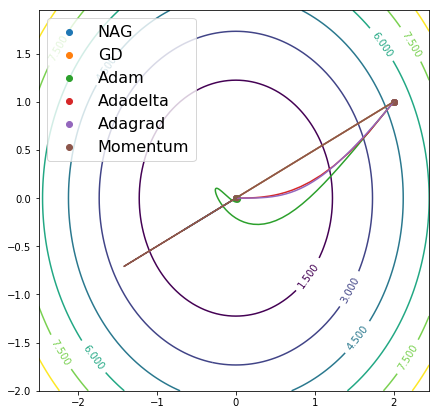

In [7]:
place = {}
for name , optim in optimizers.iteritems():
    place[name] = np.zeros([N_ITERS, 2])
    
for _ in xrange(N_ITERS):
    for name in optimizers.iterkeys():
        place[name][_] = optimizers[name].func.parameters['point']
        optimizers[name].step()
        
plt.figure(figsize=(7,7))
plot_contour(func, -2.5, 2.5, -2, 2, 0.05)
for name in place.keys():
    plt.scatter([place[name][0,0], place[name][-1,0]], [place[name][0,1], place[name][-1,1]], label=name)
    plt.plot(place[name][:,0], place[name][:,1])
    
plt.legend(fontsize=16)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [8]:
f = lambda X: X[0]**2 * math.sin(X[0]) + X[1]**2 * math.sin(X[1])
df = lambda X: np.array([X[0] * (2 *  math.sin(X[0]) + X[0] * math.cos(X[0])), 
                         X[1] * (2 *  math.sin(X[1]) + X[1] * math.cos(X[1]))])

func = Funcional(f, df, np.array([2.,1]))

optimizers = {
    'GD' : GD(func, lr=0.1),
    'Momentum' : Momentum(func, lr=0.1, gamma=0.9),
    'NAG' : NAG(func, lr=0.1, gamma=0.9),
    'Adagrad' : Adagrad(func, lr=0.1, eps=1e-8),
    'Adadelta' : Adadelta(func, lr=0.1, gamma=0.9, eps=1e-8),
    'Adam' : Adam(func, lr=0.1, gamma=0.9, delta=0.999, eps=1e-8)
}

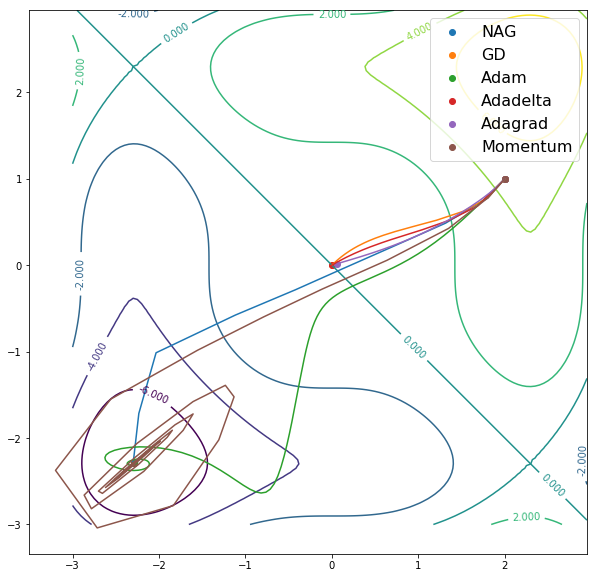

In [9]:
place = {}
for name , optim in optimizers.iteritems():
    place[name] = np.zeros([N_ITERS, 2])
    
for _ in xrange(N_ITERS):
    for name in optimizers.iterkeys():
        place[name][_] = optimizers[name].func.parameters['point']
        optimizers[name].step()
        
plt.figure(figsize=(10,10))
plot_contour(func, -3, 3, -3, 3, 0.05)
for name in place.keys():
    plt.scatter([place[name][0,0], place[name][-1,0]], [place[name][0,1], place[name][-1,1]], label=name)
    plt.plot(place[name][:,0], place[name][:,1])
    
plt.legend(fontsize=16)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [10]:
f = lambda X: X[0]**2 * math.sin(X[0] ** 2) + X[1]**2 * math.sin(X[1] ** 2)
df = lambda X: np.array([2 * X[0] * (math.sin(X[0]**2) + X[0]**2 * math.cos(X[0]**2)), 
                         2 * X[1] * (math.sin(X[1]**2) + X[1]**2 * math.cos(X[1]**2))])


func = Funcional(f, df, np.array([1.45,1.4]))

optimizers = {
    'GD' : GD(func, lr=0.01),
    'Momentum' : Momentum(func, lr=0.01, gamma=0.9),
    'NAG' : NAG(func, lr=0.1, gamma=0.9),
    'Adagrad' : Adagrad(func, lr=0.1, eps=1e-8),
    'Adadelta' : Adadelta(func, lr=0.1, gamma=0.9, eps=1e-8),
    'Adam' : Adam(func, lr=0.1, gamma=0.9, delta=0.999, eps=1e-8)
}

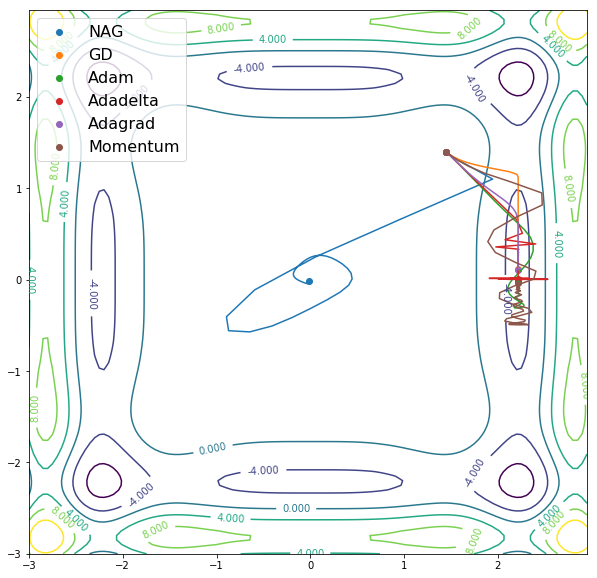

In [11]:
place = {}
for name , optim in optimizers.iteritems():
    place[name] = np.zeros([N_ITERS, 2])
    
for _ in xrange(N_ITERS):
    for name in optimizers.iterkeys():
        place[name][_] = optimizers[name].func.parameters['point']
        optimizers[name].step()
        
plt.figure(figsize=(10,10))
plot_contour(func, -3, 3, -3, 3, 0.05)
for name in place.keys():
    plt.scatter([place[name][0,0], place[name][-1,0]], [place[name][0,1], place[name][-1,1]], label=name)
    plt.plot(place[name][:,0], place[name][:,1])
    
plt.legend(fontsize=16)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [12]:
torch.cuda.set_device(1)

In [13]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [34]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(28//2*28//2*16, 10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
class FullConnClassifier(nn.Module):
    def __init__(self):
        super(FullConnClassifier, self).__init__()
        self.linear_layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.ELU(),
            nn.BatchNorm1d(200),
            nn.Linear(200, 100),
            nn.ELU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [35]:
if torch.cuda.is_available():
    dtype=torch.cuda.FloatTensor
else:
    dtype=torch.FloatTensor
    
def train(network, epochs, optimizer):    
    if torch.cuda.is_available():
        loss = nn.NLLLoss().cuda()
    else:
        loss = nn.NLLLoss()
    train_loss_epochs = []
    train_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                if torch.cuda.is_available():
                    X = Variable(X).cuda()
                    y = Variable(y).cuda()
                else:
                    X = Variable(X)
                    y = Variable(y)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
            train_loss_epochs += losses
            train_accuracy_epochs += accuracies
            losses = []
            accuracies = []
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}\tAccuracy: {2:.3f}'.format(
                epoch, train_loss_epochs[-1], train_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    return [train_loss_epochs, train_accuracy_epochs]

Epoch 0... (Train/Test) NLL: 0.265	Accuracy: 0.906

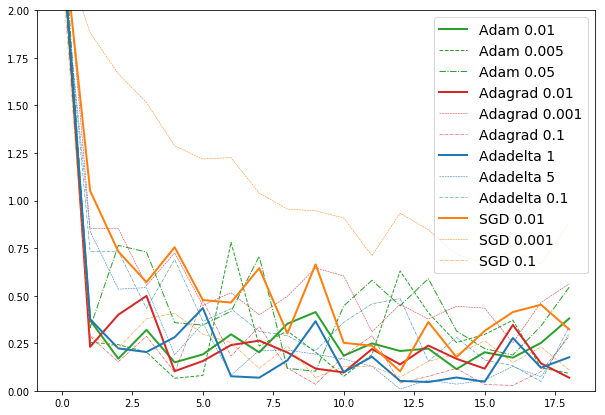

In [40]:
plt.figure(figsize=(10,7))

network = FullConnClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-', label='Adam 0.01', c='tab:green', lw=2)

network = FullConnClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=0.005)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='--', label='Adam 0.005', c='tab:green', lw=1)

network = FullConnClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=0.05)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-.', label='Adam 0.05', c='tab:green', lw=1)

network = FullConnClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adagrad(network.parameters(), lr=0.01)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-', label='Adagrad 0.01', c='tab:red', lw=2)

network = FullConnClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adagrad(network.parameters(), lr=0.001)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='--', label='Adagrad 0.001', c='tab:red', lw=0.5)

network = FullConnClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adagrad(network.parameters(), lr=0.1)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-.', label='Adagrad 0.1', c='tab:red', lw=0.5)

network = FullConnClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adadelta(network.parameters(), lr=1)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-', label='Adadelta 1', c='tab:blue', lw=2)

network = FullConnClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adadelta(network.parameters(), lr=5)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='--', label='Adadelta 5', c='tab:blue', lw=0.5)

network = FullConnClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adadelta(network.parameters(), lr=0.1)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-.', label='Adadelta 0.1', c='tab:blue', lw=0.5)

network = FullConnClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.SGD(network.parameters(), lr=0.01)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-', label='SGD 0.01', c='tab:orange', lw=2)

network = FullConnClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.SGD(network.parameters(), lr=0.001)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='--', label='SGD 0.001', c='tab:orange', lw=0.5)

network = FullConnClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.SGD(network.parameters(), lr=0.1)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-.', label='SGD 0.1', c='tab:orange', lw=0.5)

plt.ylim(0., 2.)
plt.legend(fontsize=14)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

Epoch 0... (Train/Test) NLL: nan	Accuracy: 0.09444

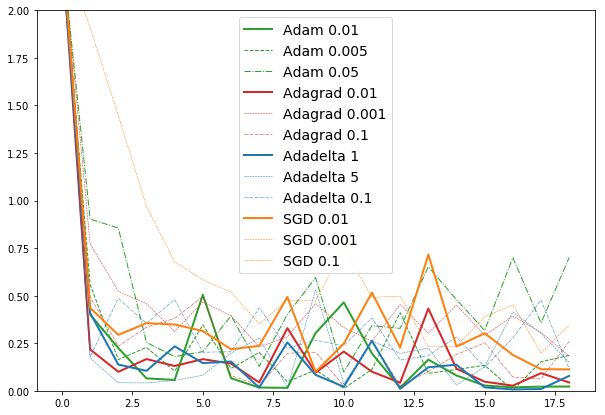

In [41]:
plt.figure(figsize=(10,7))

network = ConvClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-', label='Adam 0.01', c='tab:green', lw=2)

network = ConvClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=0.005)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='--', label='Adam 0.005', c='tab:green', lw=1)

network = ConvClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=0.05)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-.', label='Adam 0.05', c='tab:green', lw=1)

network = ConvClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adagrad(network.parameters(), lr=0.01)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-', label='Adagrad 0.01', c='tab:red', lw=2)

network = ConvClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adagrad(network.parameters(), lr=0.001)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='--', label='Adagrad 0.001', c='tab:red', lw=0.5)

network = ConvClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adagrad(network.parameters(), lr=0.1)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-.', label='Adagrad 0.1', c='tab:red', lw=0.5)

network = ConvClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adadelta(network.parameters(), lr=1)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-', label='Adadelta 1', c='tab:blue', lw=2)

network = ConvClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adadelta(network.parameters(), lr=5)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='--', label='Adadelta 5', c='tab:blue', lw=0.5)

network = ConvClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.Adadelta(network.parameters(), lr=0.1)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-.', label='Adadelta 0.1', c='tab:blue', lw=0.5)

network = ConvClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.SGD(network.parameters(), lr=0.01)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-', label='SGD 0.01', c='tab:orange', lw=2)

network = ConvClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.SGD(network.parameters(), lr=0.001)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='--', label='SGD 0.001', c='tab:orange', lw=0.5)

network = ConvClassifier()
if torch.cuda.is_available():
    network = network.cuda()
optimizer = torch.optim.SGD(network.parameters(), lr=0.1)
losses, accuracies = train(network, 1, optimizer)
plt.plot(losses[::2][::50], ls='-.', label='SGD 0.1', c='tab:orange', lw=0.5)

plt.ylim(0., 2.)
plt.legend(fontsize=14)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: